In [1]:
import torch
import torch.nn as nn
from torch._dynamo import OptimizedModule
from acvl_utils.cropping_and_padding.padding import pad_nd_image
from typing import Tuple, Union, List, Optional
import numpy as np
from tqdm import tqdm
import itertools

In [2]:
import socket
print("Current Node:", socket.gethostname())

Current Node: bessemer-node001.shef.ac.uk


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:91:
sitk::ERROR: The file "/mnt/fastdata/acs23yz/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data//Dataset001_BrainTumour/imagesTr/BRATS_314_0000.nii.gz" does not exist.

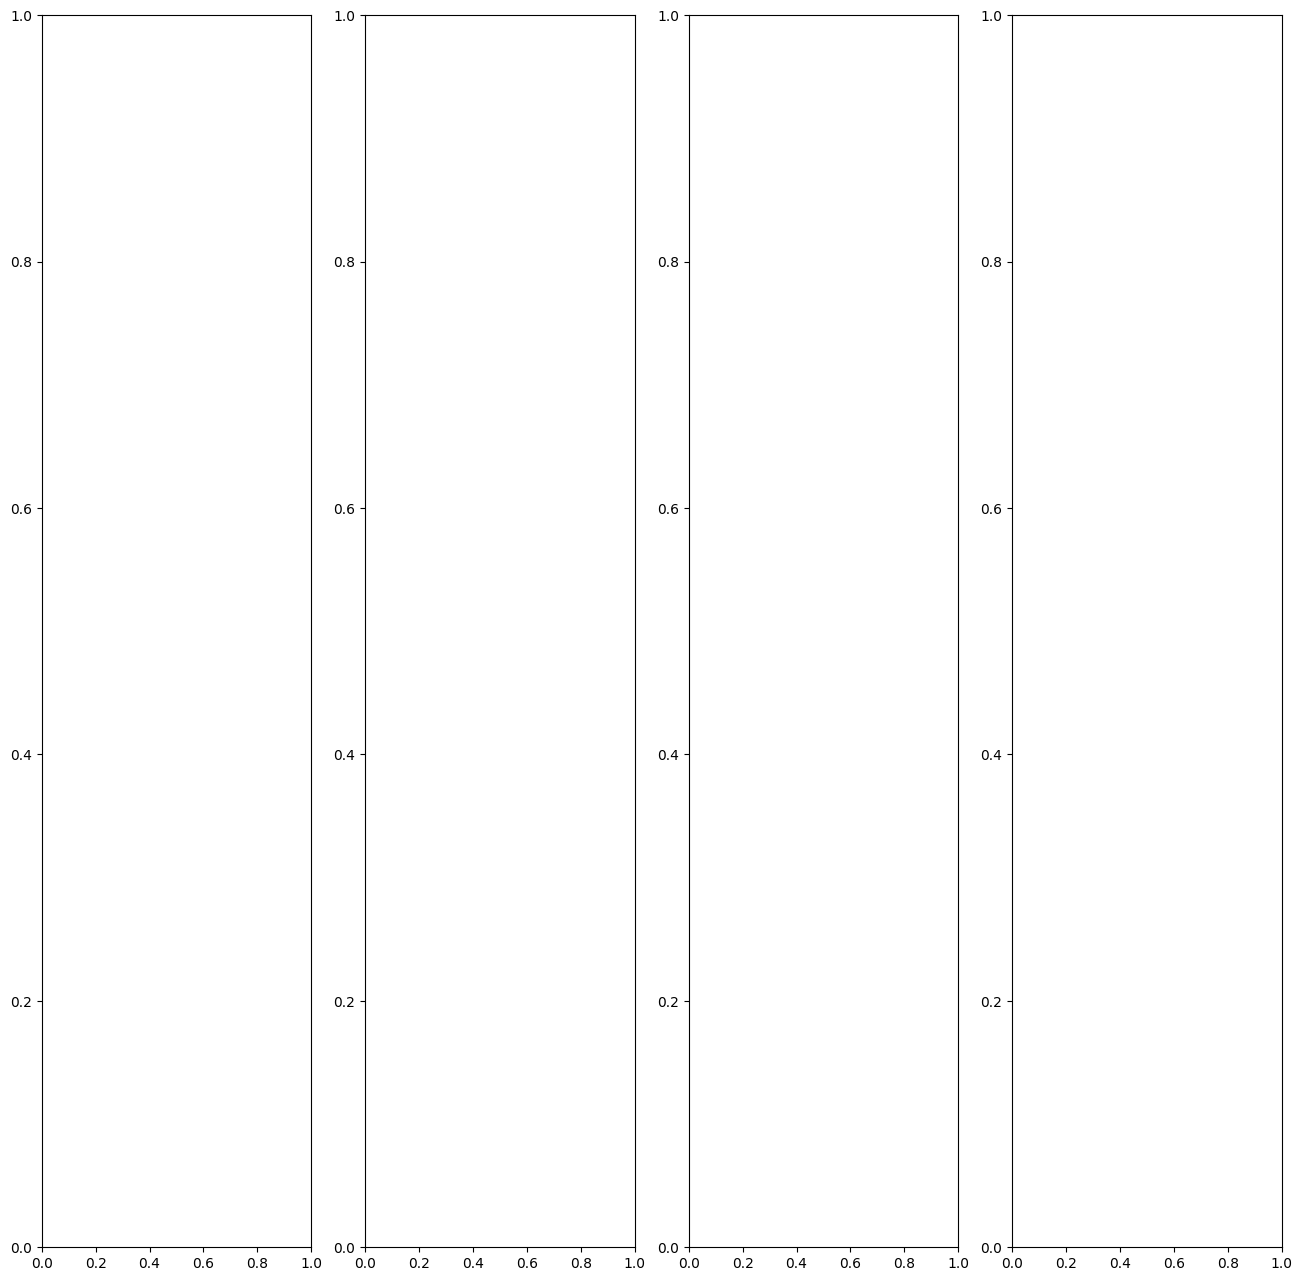

In [3]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

%matplotlib inline

number = 314

nnUNet_raw = '/mnt/fastdata/acs23yz/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/'
epsilon = 1

# 读取nii.gz文件
file_path_list = [nnUNet_raw + f'/Dataset001_BrainTumour/imagesTr/BRATS_{number}_0000.nii.gz', 
                  nnUNet_raw + f'/Dataset001_BrainTumour/imagesTr/BRATS_{number}_0001.nii.gz', 
                  nnUNet_raw + f'/Dataset001_BrainTumour/imagesTr/BRATS_{number}_0002.nii.gz', 
                  nnUNet_raw + f'/Dataset001_BrainTumour/imagesTr/BRATS_{number}_0003.nii.gz']
file_path_label = [nnUNet_raw + f'/Task01_BrainTumour/labelsTr/BRATS_{number}.nii.gz']
                #    nnUNet_raw + f'/Dataset001_BrainTumour/PGD/inferTs_pgd_-1/BRATS_{number}.nii.gz',
                #    nnUNet_raw + f'/Dataset001_BrainTumour/PGD/inferTs_pgd_1/BRATS_{number}.nii.gz',
                #    nnUNet_raw + f'/Dataset001_BrainTumour/PGD/inferTs_pgd_2/BRATS_{number}.nii.gz',
                #    nnUNet_raw + f'/Dataset001_BrainTumour/PGD/inferTs_pgd_3/BRATS_{number}.nii.gz',
                #    nnUNet_raw + f'/Dataset001_BrainTumour/PGD/inferTs_pgd_4/BRATS_{number}.nii.gz']
file_path_pgd = [nnUNet_raw + f'/Dataset001_BrainTumour/imagesTs_pgd/BRATS_{number}_0000.nii.gz', 
                  nnUNet_raw + f'/Dataset001_BrainTumour/imagesTs_pgd/BRATS_{number}_0001.nii.gz', 
                  nnUNet_raw + f'/Dataset001_BrainTumour/imagesTs_pgd/BRATS_{number}_0002.nii.gz', 
                  nnUNet_raw + f'/Dataset001_BrainTumour/imagesTs_pgd/BRATS_{number}_0003.nii.gz']
file_path_pgd_epsilon = [nnUNet_raw + f'/Dataset001_BrainTumour/PGD/imagesTs_pgd_{epsilon}/BRATS_{number}_0000.nii.gz', 
                        nnUNet_raw + f'/Dataset001_BrainTumour/PGD/imagesTs_pgd_{epsilon}/BRATS_{number}_0001.nii.gz', 
                        nnUNet_raw + f'/Dataset001_BrainTumour/PGD/imagesTs_pgd_{epsilon}/BRATS_{number}_0002.nii.gz', 
                        nnUNet_raw + f'/Dataset001_BrainTumour/PGD/imagesTs_pgd_{epsilon}/BRATS_{number}_0003.nii.gz']


# 显示中间切片
def plot_middle_slice(file_path):
    if isinstance(file_path, list):
        channels = len(file_path)
        fig, ax = plt.subplots(1, channels, figsize=(16,16))
        
        for i, file in enumerate(file_path):
            img = sitk.ReadImage(file)
            data = sitk.GetArrayFromImage(img)
            print(data.shape, data.max(), data.min(), data.mean(), data.std(), np.percentile(data, 25), np.percentile(data, 75))
            middle_slice = data.shape[0] // 2
            ax[i].imshow(data[middle_slice, :, :], cmap='gray')
    else:
        img = sitk.ReadImage(file_path)
        data = sitk.GetArrayFromImage(img)
        print(data.shape, data.max(), data.min(), data.mean(), data.std())
        middle_slice = data.shape[0] // 2
        plt.imshow(data[middle_slice, :, :], cmap='gray')
        
    plt.show()

plot_middle_slice(file_path_list)
# plot_middle_slice(file_path_pgd)
# plot_middle_slice(file_path_pgd_epsilon)
# plot_middle_slice(file_path_label)

In [ ]:
import nnunetv2
from nnunetv2.configuration import default_num_processes
from nnunetv2.inference.data_iterators import PreprocessAdapterFromNpy, preprocessing_iterator_fromfiles, \
    preprocessing_iterator_fromnpy
from nnunetv2.inference.export_prediction import export_prediction_from_logits, \
    convert_predicted_logits_to_segmentation_with_correct_shape
from nnunetv2.inference.sliding_window_prediction import compute_gaussian, \
    compute_steps_for_sliding_window
from nnunetv2.utilities.file_path_utilities import get_output_folder, check_workers_alive_and_busy
from nnunetv2.utilities.find_class_by_name import recursive_find_python_class
from nnunetv2.utilities.helpers import empty_cache, dummy_context
from nnunetv2.utilities.json_export import recursive_fix_for_json_export
from nnunetv2.utilities.label_handling.label_handling import determine_num_input_channels, LabelManager
from nnunetv2.utilities.plans_handling.plans_handler import PlansManager, ConfigurationManager
from nnunetv2.utilities.utils import create_lists_from_splitted_dataset_folder

In [ ]:
import os
import json
from batchgenerators.utilities.file_and_folder_operations import join, save_pickle
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO

In [ ]:
def load_json(file: str):
    with open(file, 'r') as f:
        a = json.load(f)
    return a

In [ ]:
print(torch.__version__)

2.4.0+cu121


In [ ]:
checkpoint = torch.load(r'/mnt/fastdata/acs23yz/nnUNetFrame/DATASET/nnUNet_results/Dataset001_BrainTumour/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_0/checkpoint_final.pth',
                                    map_location=torch.device('cpu'))

/scratch/3630686/ipykernel_94790/3743445185.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r'/mnt/fastdata/acs23yz/nnUNetFrame/DATASET/nnUNet_re

In [ ]:
print(checkpoint.keys())
parameters = []
trainer_name = checkpoint['trainer_name']
configuration_name = checkpoint['init_args']['configuration']
inference_allowed_mirroring_axes = checkpoint['inference_allowed_mirroring_axes'] if \
    'inference_allowed_mirroring_axes' in checkpoint.keys() else None

parameters.append(checkpoint['network_weights'])
trainer_name, configuration_name, inference_allowed_mirroring_axes

dict_keys(['network_weights', 'optimizer_state', 'grad_scaler_state', 'logging', '_best_ema', 'current_epoch', 'init_args', 'trainer_name', 'inference_allowed_mirroring_axes'])


('nnUNetTrainer', '3d_fullres', (0, 1, 2))

In [ ]:
parameters[0]

OrderedDict([('encoder.stages.0.0.convs.0.conv.weight',
              tensor([[[[[ 2.4309e-01, -6.1692e-02, -9.2989e-02],
                         [-1.9269e-01, -1.5820e-01, -7.7528e-02],
                         [-5.5381e-02,  6.8821e-04,  6.4549e-02]],
              
                        [[-2.0968e-01,  7.5195e-02, -1.5230e-01],
                         [-2.1036e-01, -3.2485e-01, -1.2796e-01],
                         [ 1.0356e-01, -9.8188e-02,  1.5300e-01]],
              
                        [[ 2.1099e-01,  1.3919e-01,  2.4429e-01],
                         [-6.7441e-02, -1.9755e-01,  1.5887e-01],
                         [ 3.3675e-01, -3.9365e-02,  2.4582e-01]]],
              
              
                       [[[-1.0098e-01, -2.2022e-01, -1.4079e-01],
                         [ 4.4804e-02, -1.8241e-02, -1.3308e-01],
                         [ 1.7948e-01, -3.6132e-02, -1.1360e-01]],
              
                        [[-7.5155e-03,  1.3885e-01, -2.2919e-01],
      

In [ ]:
for params, value in parameters[0].items():
    print(params, value.shape)

encoder.stages.0.0.convs.0.conv.weight torch.Size([32, 4, 3, 3, 3])
encoder.stages.0.0.convs.0.conv.bias torch.Size([32])
encoder.stages.0.0.convs.0.norm.weight torch.Size([32])
encoder.stages.0.0.convs.0.norm.bias torch.Size([32])
encoder.stages.0.0.convs.0.all_modules.0.weight torch.Size([32, 4, 3, 3, 3])
encoder.stages.0.0.convs.0.all_modules.0.bias torch.Size([32])
encoder.stages.0.0.convs.0.all_modules.1.weight torch.Size([32])
encoder.stages.0.0.convs.0.all_modules.1.bias torch.Size([32])
encoder.stages.0.0.convs.1.conv.weight torch.Size([32, 32, 3, 3, 3])
encoder.stages.0.0.convs.1.conv.bias torch.Size([32])
encoder.stages.0.0.convs.1.norm.weight torch.Size([32])
encoder.stages.0.0.convs.1.norm.bias torch.Size([32])
encoder.stages.0.0.convs.1.all_modules.0.weight torch.Size([32, 32, 3, 3, 3])
encoder.stages.0.0.convs.1.all_modules.0.bias torch.Size([32])
encoder.stages.0.0.convs.1.all_modules.1.weight torch.Size([32])
encoder.stages.0.0.convs.1.all_modules.1.bias torch.Size([32]

In [ ]:
torch.cuda.is_available()

False

In [ ]:
dataset_json = load_json(r'/mnt/fastdata/acs23yz/nnUNetFrame/DATASET/nnUNet_results/Dataset001_BrainTumour/nnUNetTrainer__nnUNetPlans__3d_fullres/dataset.json')
plans = load_json(r'/mnt/fastdata/acs23yz/nnUNetFrame/DATASET/nnUNet_results/Dataset001_BrainTumour/nnUNetTrainer__nnUNetPlans__3d_fullres/plans.json')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
verbose = True
tile_step_size = 0.5
plans_manager = PlansManager(plans)
configuration_manager = plans_manager.get_configuration(configuration_name=configuration_name)
label_manager = plans_manager.get_label_manager(dataset_json)
num_input_channels = determine_num_input_channels(plans_manager, configuration_manager, dataset_json)
trainer_class = recursive_find_python_class(join(nnunetv2.__path__[0], "training", "nnUNetTrainer"),
                                                    trainer_name, 'nnunetv2.training.nnUNetTrainer')
num_input_channels, label_manager, trainer_class

(4,
 nnunetv2.training.nnUNetTrainer.nnUNetTrainer.nnUNetTrainer)

In [ ]:
network = trainer_class.build_network_architecture(
            configuration_manager.network_arch_class_name,
            configuration_manager.network_arch_init_kwargs,
            configuration_manager.network_arch_init_kwargs_req_import,
            num_input_channels,
            plans_manager.get_label_manager(dataset_json).num_segmentation_heads,
            enable_deep_supervision=False
        )
if ('nnUNet_compile' in os.environ.keys()) and (os.environ['nnUNet_compile'].lower() in ('true', '1', 't')) \
        and not isinstance(network, OptimizedModule):
    print('Using torch.compile')
    network = torch.compile(network)
    
network

PlainConvUNet(
  (encoder): PlainConvEncoder(
    (stages): Sequential(
      (0): Sequential(
        (0): StackedConvBlocks(
          (convs): Sequential(
            (0): ConvDropoutNormReLU(
              (conv): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (norm): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
              (nonlin): LeakyReLU(negative_slope=0.01, inplace=True)
              (all_modules): Sequential(
                (0): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
                (2): LeakyReLU(negative_slope=0.01, inplace=True)
              )
            )
            (1): ConvDropoutNormReLU(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (norm): InstanceNorm3d(32, eps=1e-05, momentum=

In [ ]:
for params in parameters:
    print(params)
    if not isinstance(network, OptimizedModule):
        network.load_state_dict(params)
    else:
        network._orig_mod.load_state_dict(params)

network

OrderedDict([('encoder.stages.0.0.convs.0.conv.weight', tensor([[[[[ 2.4309e-01, -6.1692e-02, -9.2989e-02],
           [-1.9269e-01, -1.5820e-01, -7.7528e-02],
           [-5.5381e-02,  6.8821e-04,  6.4549e-02]],

          [[-2.0968e-01,  7.5195e-02, -1.5230e-01],
           [-2.1036e-01, -3.2485e-01, -1.2796e-01],
           [ 1.0356e-01, -9.8188e-02,  1.5300e-01]],

          [[ 2.1099e-01,  1.3919e-01,  2.4429e-01],
           [-6.7441e-02, -1.9755e-01,  1.5887e-01],
           [ 3.3675e-01, -3.9365e-02,  2.4582e-01]]],


         [[[-1.0098e-01, -2.2022e-01, -1.4079e-01],
           [ 4.4804e-02, -1.8241e-02, -1.3308e-01],
           [ 1.7948e-01, -3.6132e-02, -1.1360e-01]],

          [[-7.5155e-03,  1.3885e-01, -2.2919e-01],
           [ 6.6104e-02, -7.2015e-02, -2.1259e-02],
           [-6.8203e-02, -3.9494e-02, -9.8074e-02]],

          [[-6.4337e-02,  2.2652e-01,  3.2997e-02],
           [ 6.4650e-02,  2.9701e-01,  1.8142e-01],
           [ 2.9432e-01,  1.8221e-01,  6.2829e-0

PlainConvUNet(
  (encoder): PlainConvEncoder(
    (stages): Sequential(
      (0): Sequential(
        (0): StackedConvBlocks(
          (convs): Sequential(
            (0): ConvDropoutNormReLU(
              (conv): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (norm): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
              (nonlin): LeakyReLU(negative_slope=0.01, inplace=True)
              (all_modules): Sequential(
                (0): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
                (2): LeakyReLU(negative_slope=0.01, inplace=True)
              )
            )
            (1): ConvDropoutNormReLU(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (norm): InstanceNorm3d(32, eps=1e-05, momentum=

In [ ]:
print(
    "Number of total parameters: ",
    sum(p.numel() for _, p in parameters[0].items()),
)  # 88632372

Number of total parameters:  88632372


In [ ]:
configuration_manager.patch_size, len(configuration_manager.patch_size)

([128, 128, 128], 3)

In [ ]:
def _internal_get_sliding_window_slicers(image_size: Tuple[int, ...]):
    """Get sliding windows for given image_size"""

    slicers = []
    if len(configuration_manager.patch_size) < len(image_size):
        assert len(configuration_manager.patch_size) == len(
            image_size) - 1, 'if tile_size has less entries than image_size, ' \
                                'len(tile_size) ' \
                                'must be one shorter than len(image_size) ' \
                                '(only dimension ' \
                                'discrepancy of 1 allowed).'
        steps = compute_steps_for_sliding_window(image_size[1:], configuration_manager.patch_size,
                                                    tile_step_size)
        if verbose: print(f'n_steps {image_size[0] * len(steps[0]) * len(steps[1])}, image size is'
                                f' {image_size}, tile_size {configuration_manager.patch_size}, '
                                f'tile_step_size {tile_step_size}\nsteps:\n{steps}')
        for d in range(image_size[0]):
            for sx in steps[0]:
                for sy in steps[1]:
                    slicers.append(
                        tuple([slice(None), d, *[slice(si, si + ti) for si, ti in
                                                    zip((sx, sy), configuration_manager.patch_size)]]))
    else:
        steps = compute_steps_for_sliding_window(image_size, configuration_manager.patch_size,
                                                    tile_step_size)
        if verbose: print(
            f'n_steps {np.prod([len(i) for i in steps])}, image size is {image_size}, tile_size {configuration_manager.patch_size}, '
            f'tile_step_size {tile_step_size}\nsteps:\n{steps}')
        for sx in steps[0]:
            for sy in steps[1]:
                for sz in steps[2]:
                    slicers.append(
                        tuple([slice(None), *[slice(si, si + ti) for si, ti in
                                                zip((sx, sy, sz), configuration_manager.patch_size)]]))
    return slicers

In [ ]:
def pgd_attack(model, images, labels, eps=0.1, alpha=2/255, iters=10):
    images = images.to(device)
    labels = torch.squeeze(labels, dim=1)
    labels = labels.to(device)

    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
    print(ori_images.shape)
    plt.imshow(ori_images[64, :, :], cmap='gray')
        
    for i in range(iters):    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        print(cost)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        pertubation = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = ori_images + pertubation
        images = images.detach_()

        plt.imshow(images[64, :, :], cmap='gray')
            
    return images

In [ ]:
label_manager.num_segmentation_heads

4

In [ ]:
list_of_lists_or_source_folder = nnUNet_raw + '/Dataset001_BrainTumour/imagesTs/'
if isinstance(list_of_lists_or_source_folder, str):
    list_of_lists_or_source_folder = create_lists_from_splitted_dataset_folder(list_of_lists_or_source_folder, dataset_json['file_ending'])

list_of_lists_or_source_folder[:3]

[['/mnt/parscratch/users/acs23yz/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Dataset001_BrainTumour/imagesTs/BRATS_314_0000.nii.gz',
  '/mnt/parscratch/users/acs23yz/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Dataset001_BrainTumour/imagesTs/BRATS_314_0001.nii.gz',
  '/mnt/parscratch/users/acs23yz/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Dataset001_BrainTumour/imagesTs/BRATS_314_0002.nii.gz',
  '/mnt/parscratch/users/acs23yz/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Dataset001_BrainTumour/imagesTs/BRATS_314_0003.nii.gz'],
 ['/mnt/parscratch/users/acs23yz/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Dataset001_BrainTumour/imagesTs/BRATS_315_0000.nii.gz',
  '/mnt/parscratch/users/acs23yz/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Dataset001_BrainTumour/imagesTs/BRATS_315_0001.nii.gz',
  '/mnt/parscratch/users/acs23yz/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Dataset001_BrainTumour/imagesTs/BRATS_315_0002.nii.gz',
  '/mnt/parscratch/users/acs23yz/nnUNetFrame/DA

In [ ]:
plans_manager.transpose_forward, plans_manager.image_reader_writer_class()

([0, 1, 2],
 <nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO at 0x7f7e4c1e6160>)

In [ ]:
from scipy.ndimage import binary_fill_holes

# Hello! crop_to_nonzero is the function you are looking for. Ignore the rest.
from acvl_utils.cropping_and_padding.bounding_boxes import get_bbox_from_mask, crop_to_bbox, bounding_box_to_slice


def create_nonzero_mask(data):
    """

    :param data:
    :return: the mask is True where the data is nonzero
    """
    assert data.ndim in (3, 4), "data must have shape (C, X, Y, Z) or shape (C, X, Y)"
    nonzero_mask = data[0] != 0
    for c in range(1, data.shape[0]):
        nonzero_mask |= data[c] != 0
    return binary_fill_holes(nonzero_mask)


def crop_to_nonzero(data, seg=None, nonzero_label=-1):
    """

    :param data:
    :param seg:
    :param nonzero_label: this will be written into the segmentation map
    :return:
    """
    nonzero_mask = create_nonzero_mask(data)
    bbox = get_bbox_from_mask(nonzero_mask)
    slicer = bounding_box_to_slice(bbox)
    nonzero_mask = nonzero_mask[slicer][None]
    
    slicer = (slice(None), ) + slicer
    data = data[slicer]
    if seg is not None:
        seg = seg[slicer]
        seg[(seg == 0) & (~nonzero_mask)] = nonzero_label
    else:
        seg = np.where(nonzero_mask, np.int8(0), np.int8(nonzero_label))
    return data, seg, bbox

def crop_to_nonzero_label(data, label):
    """

    :param data:
    :param seg:
    :param nonzero_label: this will be written into the segmentation map
    :return:
    """
    assert data[0].shape == label[0].shape, f'{data[0].shape} != {label[0].shape}'
    nonzero_mask = create_nonzero_mask(data)
    bbox = get_bbox_from_mask(nonzero_mask)
    slicer = bounding_box_to_slice(bbox)
    nonzero_mask = nonzero_mask[slicer][None]
    
    slicer = (slice(None), ) + slicer
    label = label[slicer]

    return label

In [ ]:
from nnunetv2.preprocessing.cropping.cropping import crop_to_nonzero
from nnunetv2.preprocessing.resampling.default_resampling import compute_new_shape

def run_case(image_files: List[str], seg_file: Union[str, None], plans_manager: PlansManager,
                 configuration_manager: ConfigurationManager,
                 dataset_json: Union[dict, str]):
    rw = plans_manager.image_reader_writer_class()

    # load image(s)
    data, data_properties = rw.read_images(image_files)
    # if possible, load seg
    if seg_file is not None:
        seg, _ = rw.read_seg(seg_file)
    else:
        seg = None

    data, seg = run_case_npy(data, seg, data_properties, plans_manager, configuration_manager, dataset_json)
    return data, seg, data_properties

def run_case_npy(data: np.ndarray, seg: Union[np.ndarray, None], properties: dict,
                     plans_manager: PlansManager, configuration_manager: ConfigurationManager,
                     dataset_json: Union[dict, str]):
     # let's not mess up the inputs!
        data = data.astype(np.float32)  # this creates a copy
        if seg is not None:
            assert data.shape[1:] == seg.shape[1:], "Shape mismatch between image and segmentation. Please fix your dataset and make use of the --verify_dataset_integrity flag to ensure everything is correct"
            seg = np.copy(seg)

        # apply transpose_forward, this also needs to be applied to the spacing!
        data = data.transpose([0, *[i + 1 for i in plans_manager.transpose_forward]])
        if seg is not None:
            seg = seg.transpose([0, *[i + 1 for i in plans_manager.transpose_forward]])
        original_spacing = [properties['spacing'][i] for i in plans_manager.transpose_forward]

        # crop, remember to store size before cropping!
        shape_before_cropping = data.shape[1:]
        properties['shape_before_cropping'] = shape_before_cropping
        # this command will generate a segmentation. This is important because of the nonzero mask which we may need
        data, seg, bbox = crop_to_nonzero(data, seg)
        properties['bbox_used_for_cropping'] = bbox
        properties['shape_after_cropping_and_before_resampling'] = data.shape[1:]

        # resample
        target_spacing = configuration_manager.spacing  # this should already be transposed

        if len(target_spacing) < len(data.shape[1:]):
            # target spacing for 2d has 2 entries but the data and original_spacing have three because everything is 3d
            # in 2d configuration we do not change the spacing between slices
            target_spacing = [original_spacing[0]] + target_spacing
        new_shape = compute_new_shape(data.shape[1:], original_spacing, target_spacing)

        # normalize
        # normalization MUST happen before resampling or we get huge problems with resampled nonzero masks no
        # longer fitting the images perfectly!
        print(f'Before normalization: {data.shape}')
        for c in range(data.shape[0]):
            data[c] = normalize(data[c], seg[0])

        # print('current shape', data.shape[1:], 'current_spacing', original_spacing,
        #       '\ntarget shape', new_shape, 'target_spacing', target_spacing)
        old_shape = data.shape[1:]
        data = configuration_manager.resampling_fn_data(data, new_shape, original_spacing, target_spacing)
        seg = configuration_manager.resampling_fn_seg(seg, new_shape, original_spacing, target_spacing)

        # print(f'old shape: {old_shape}, new_shape: {new_shape}, old_spacing: {original_spacing}, '
        #         f'new_spacing: {target_spacing}, fn_data: {configuration_manager.resampling_fn_data}')

        if np.max(seg) > 127:
            seg = seg.astype(np.int16)
        else:
            seg = seg.astype(np.int8)
        return data, seg

In [ ]:
def normalize(image: np.ndarray, seg: np.ndarray = None) -> np.ndarray:
    image = image.astype(np.float32, copy=False)
    # negative values in the segmentation encode the 'outside' region (think zero values around the brain as
    # in BraTS). We want to run the normalization only in the brain region, so we need to mask the image.
    # The default nnU-net sets use_mask_for_norm to True if cropping to the nonzero region substantially
    # reduced the image size.
    mask = seg >= 0
    mean = image[mask].mean()
    std = image[mask].std()
    image[mask] = (image[mask] - mean) / (max(std, 1e-8))
    image[mask] -=  image[mask].min()
    image[~mask] = 0

    return image

In [ ]:
data, seg, data_properties = run_case(list_of_lists_or_source_folder[0],
                                                            None,
                                                            plans_manager,
                                                            configuration_manager,
                                                            dataset_json)
# rw = plans_manager.image_reader_writer_class()
# data, data_properties = rw.read_images(list_of_lists_or_source_folder[0])

print(1, data.shape, data.mean(), data.std(), data.max(), data.min())
data = torch.from_numpy(data).to(dtype=torch.float32, memory_format=torch.contiguous_format)

data, slicer_revert_padding = pad_nd_image(data, configuration_manager.patch_size,
                                                'constant', {'value': 0}, True,
                                                None)
print(2, data.shape)
slicers = _internal_get_sliding_window_slicers(data.shape[1:])
sl = slicers[0]
workon = data[sl][None]
workon.requires_grad = True
print(3, sl, workon.shape)

prediction = network(workon)
print(f'Prediction shape is {prediction.shape}')

Before normalization: (4, 139, 180, 140)
1 (4, 139, 180, 140) 1.3540401 1.7094952 14.211105 0.0
2 torch.Size([4, 139, 180, 140])
n_steps 8, image size is torch.Size([139, 180, 140]), tile_size [128, 128, 128], tile_step_size 0.5
steps:
[[0, 11], [0, 52], [0, 12]]
3 (slice(None, None, None), slice(0, 128, None), slice(0, 128, None), slice(0, 128, None)) torch.Size([1, 4, 128, 128, 128])
Prediction shape is torch.Size([1, 4, 128, 128, 128])


In [ ]:
data_properties

{'sitk_stuff': {'spacing': (1.0, 1.0, 1.0),
  'origin': (0.0, 0.0, 0.0),
  'direction': (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)},
 'spacing': [1.0, 1.0, 1.0],
 'shape_before_cropping': (155, 240, 240),
 'bbox_used_for_cropping': [[0, 139], [22, 202], [51, 191]],
 'shape_after_cropping_and_before_resampling': (139, 180, 140)}

In [ ]:
rw = plans_manager.image_reader_writer_class()
data, data_properties = rw.read_images(list_of_lists_or_source_folder[0])
print(1, data.shape)

y_label_path = nnUNet_raw + f'/Task01_BrainTumour/labelsTs/BRATS_314.nii.gz'
y, y_prop = rw.read_seg(y_label_path)
print(y.shape)
y = y.transpose([0, *[i + 1 for i in plans_manager.transpose_forward]])

y = crop_to_nonzero_label(data, y)
print(2, y.shape)

y = torch.from_numpy(y).to(dtype=torch.long, memory_format=torch.contiguous_format)


y, _ = pad_nd_image(y, configuration_manager.patch_size,
                                                'constant', {'value': 0}, True,
                                                None)
print(y.shape)
y_on = y[sl][None]
y_on.shape, y_prop

1 (4, 155, 240, 240)
(1, 155, 240, 240)
2 (1, 139, 180, 140)
torch.Size([1, 139, 180, 140])


(torch.Size([1, 1, 128, 128, 128]),
 {'sitk_stuff': {'spacing': (1.0, 1.0, 1.0),
   'origin': (0.0, 0.0, 0.0),
   'direction': (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)},
  'spacing': [1.0, 1.0, 1.0]})

In [ ]:
gt_sitk = sitk.ReadImage(y_label_path)
gt_data_ori = np.uint8(sitk.GetArrayFromImage(gt_sitk))
z_index, _, _ = np.where(gt_data_ori > 0)
z_index = np.unique(z_index)
gt_data_ori.shape, z_index

((155, 240, 240),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
        66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
        83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]))

In [ ]:
y.max(), y.min(), y_on.max(), y_on.min()

(tensor(3), tensor(0), tensor(3), tensor(0))

In [ ]:
for sl in slicers:
    print(sl)

(slice(None, None, None), slice(0, 128, None), slice(0, 128, None), slice(0, 128, None))
(slice(None, None, None), slice(0, 128, None), slice(0, 128, None), slice(12, 140, None))
(slice(None, None, None), slice(0, 128, None), slice(52, 180, None), slice(0, 128, None))
(slice(None, None, None), slice(0, 128, None), slice(52, 180, None), slice(12, 140, None))
(slice(None, None, None), slice(11, 139, None), slice(0, 128, None), slice(0, 128, None))
(slice(None, None, None), slice(11, 139, None), slice(0, 128, None), slice(12, 140, None))
(slice(None, None, None), slice(11, 139, None), slice(52, 180, None), slice(0, 128, None))
(slice(None, None, None), slice(11, 139, None), slice(52, 180, None), slice(12, 140, None))


In [ ]:
def fgsm_attack(model, images, labels, eps):
    images = images.to(device)
    labels = torch.squeeze(labels, dim=1)
    labels = labels.to(device)

    loss = nn.CrossEntropyLoss()
    loss_record = []
        
    ori_images = images.data

    images.requires_grad = True
    output = model(images)

    model.zero_grad()
    cost = loss(output, labels)

    # 反向传播来获取梯度
    cost.backward()

    # 使用梯度的符号来生成对抗样本
    pertubation = eps * images.grad.sign()
    print(pertubation.shape, pertubation.max())
    adv_images = images + pertubation
    adv_images = adv_images.detach()

    _, ax = plt.subplots(5, 4, figsize=(16,16))
    for i in range(4):
        image = ori_images.squeeze(0)[i]
        # print(image.shape, image.max(), image.min(), image.mean(), image.std())
        label = labels.squeeze(0)
        # print(label.shape)
        middle_slice = image.shape[0] // 2
        ax[0][i].imshow(image[middle_slice, :, :], cmap='gray')
        ax[1][i].imshow(pertubation.squeeze(0)[i][middle_slice, :, :], cmap='gray')
        ax[2][i].imshow(adv_images.squeeze(0)[i][middle_slice, :, :], cmap='gray')
        ax[3][i].imshow(label[middle_slice, :, :], cmap='gray')
        ax[4][i].imshow(output[middle_slice, :, :], cmap='gray')
        
    plt.show()

    return adv_images, cost

torch.Size([1, 4, 128, 128, 128]) tensor(0.3000)


IndexError: index 64 is out of bounds for dimension 0 with size 1

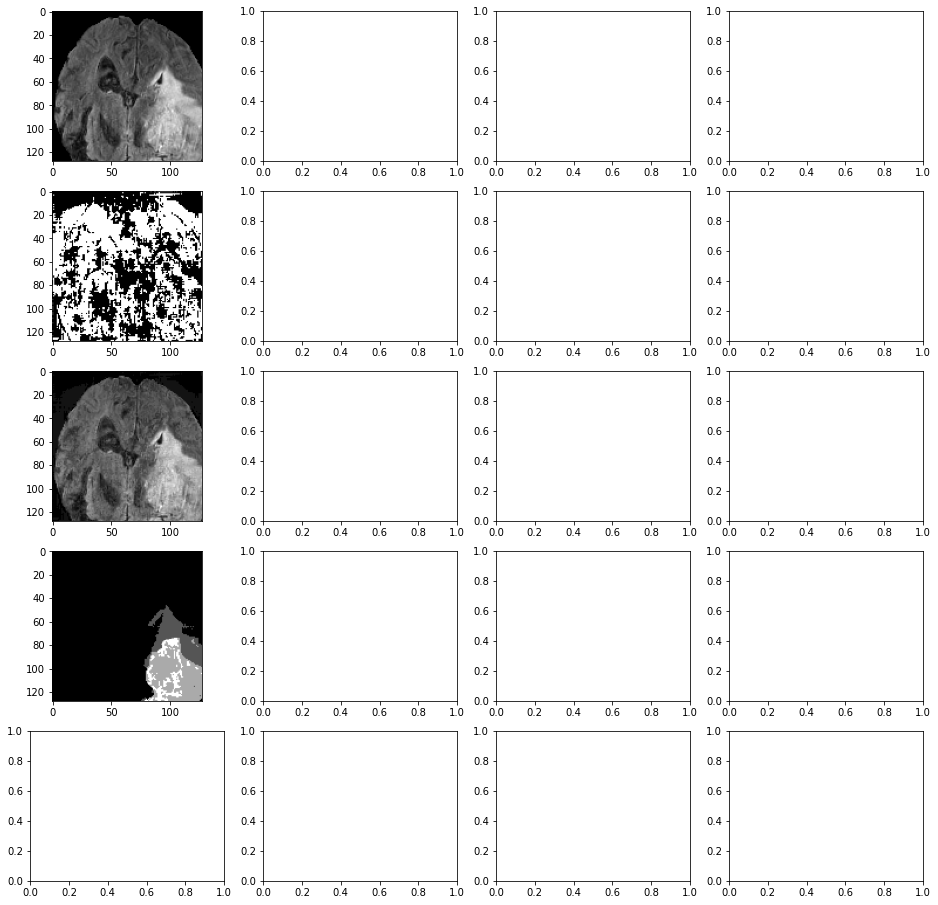

: 

In [ ]:
loss_record_fgsm = []
for i in range(-3,6):
    eps = i / 10
    x_adv_fgsm, loss_fgsm = fgsm_attack(network, workon, y_on, eps=eps)
    loss_record_fgsm.append(loss_fgsm)

plt.plot([i.data for i in loss_record_fgsm])
plt.show()

In [ ]:
def pgd_attack(model, images, labels, eps=0.3, alpha=0.01, iters=10):
    images = images.to(device)
    labels = torch.squeeze(labels, dim=1)
    labels = labels.to(device)

    loss = nn.CrossEntropyLoss()
    loss_record = []
        
    ori_images = images.data
    # print(f'START IMAGE: {ori_images.shape}')
    # print(f'START LABEL: {labels.shape}')
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        loss_record.append(cost)
        print(print(f'Epoch {i + 1}: {cost:.4f}'))
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = ori_images + eta
        images = images.detach_()

        # if (i+1) % 5 == 0:
        #     fig, ax = plt.subplots(1, 4, figsize=(16,16))
            
        #     for i in range(4):
        #         image = images.data.squeeze(0)[i]
        #         # print(f'Shape: {image.shape}, Max: {image.max()}, Min:{image.min()}, Mean:{image.mean()}, Std:{image.std()}')
        #         middle_slice = image.shape[0] // 2
        #         ax[i].imshow(image[middle_slice, :, :], cmap='gray')
        #     plt.show()
    
    fig, ax = plt.subplots(3, 4, figsize=(16,16))
    
    for i in range(4):
        image = ori_images.squeeze(0)[i]
        # print(image.shape, image.max(), image.min(), image.mean(), image.std())
        label = labels.squeeze(0)
        # print(label.shape)
        middle_slice = image.shape[0] // 2
        ax[0][i].imshow(image[middle_slice, :, :], cmap='gray')
        ax[1][i].imshow(images.squeeze(0)[i][middle_slice, :, :], cmap='gray')
        ax[2][i].imshow(label[middle_slice, :, :], cmap='gray')
        
    plt.show()
            
    return images, loss_record

torch.Size([1, 1, 128, 128, 128])
torch.Size([128, 128, 128])


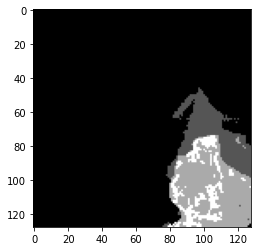

In [ ]:
print(y_on.shape)
label_temp = torch.squeeze(y_on, dim=1).squeeze(0)
print(label_temp.shape)
plt.imshow(label_temp[64, :, :], cmap='gray')

plt.show()

In [ ]:
%matplotlib inline

Epoch 1: 0.1606
None
Epoch 2: 0.2021
None
Epoch 3: 0.2471
None
Epoch 4: 0.2946
None
Epoch 5: 0.3437
None
Epoch 6: 0.3911
None
Epoch 7: 0.4363
None
Epoch 8: 0.4801
None
Epoch 9: 0.5235
None
Epoch 10: 0.5685
None


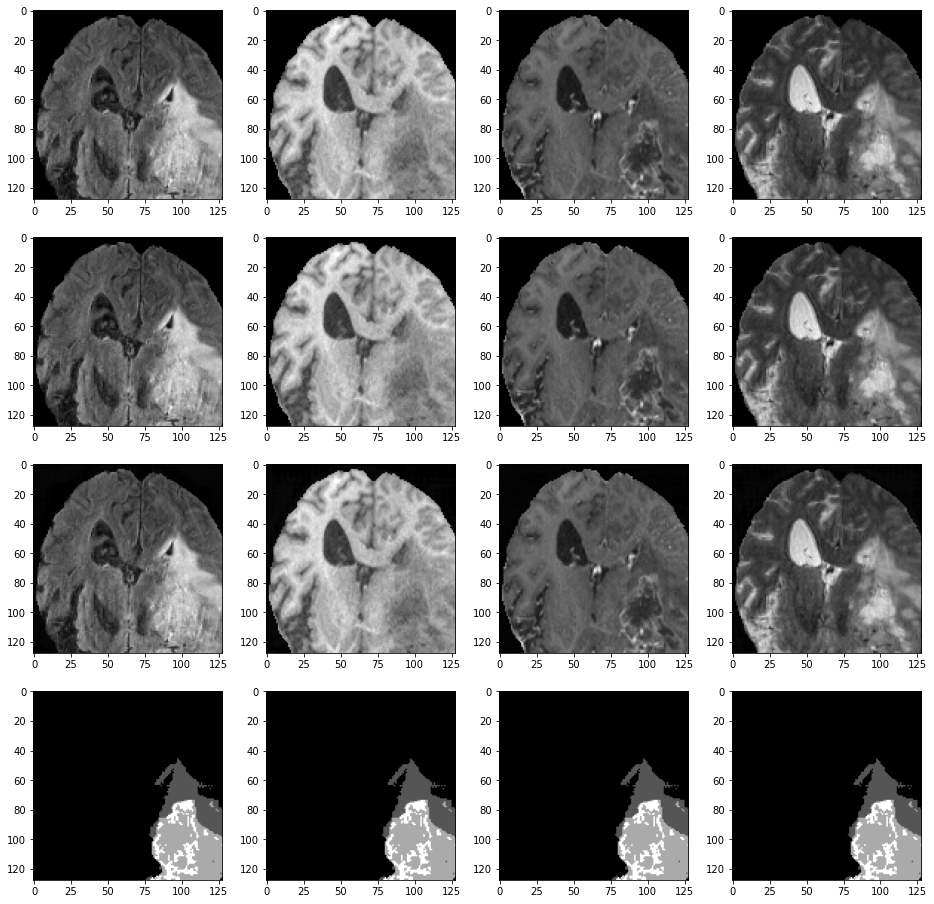

Epoch 1: 0.1606
None
Epoch 2: 0.2021
None
Epoch 3: 0.2471
None
Epoch 4: 0.2946
None
Epoch 5: 0.3437
None
Epoch 6: 0.3911
None
Epoch 7: 0.4363
None
Epoch 8: 0.4801
None
Epoch 9: 0.5235
None
Epoch 10: 0.5685
None


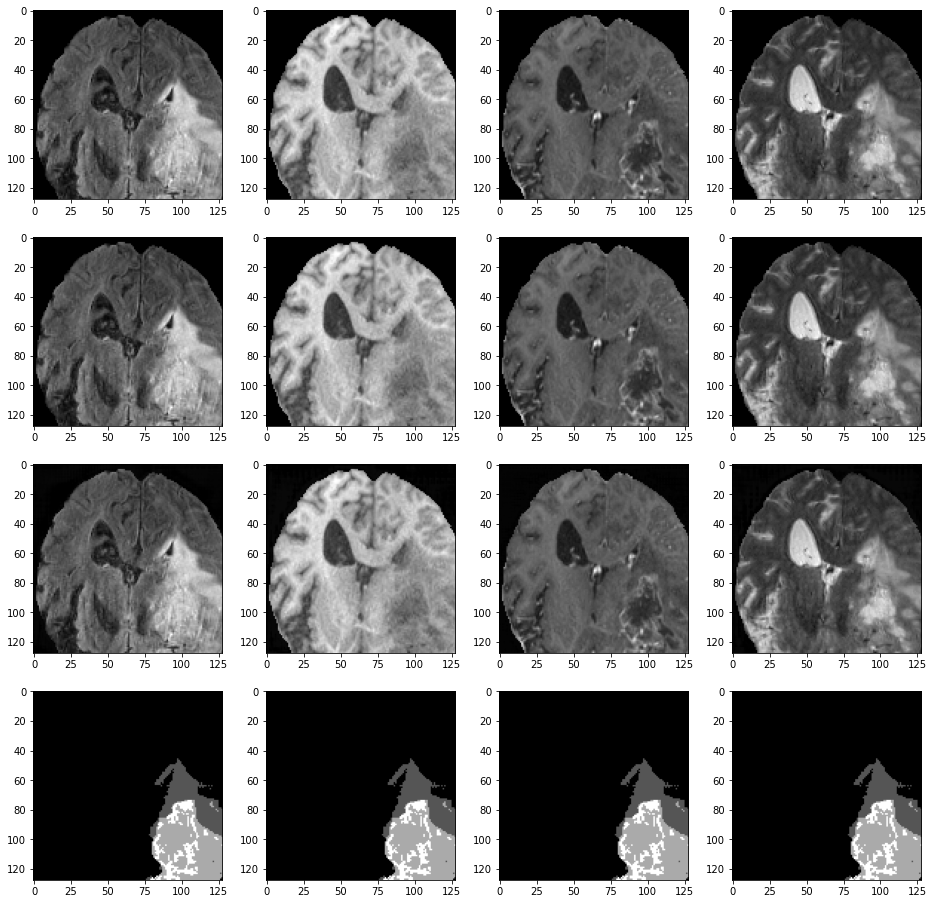

Epoch 1: 0.1606
None
Epoch 2: 0.2021
None
Epoch 3: 0.2471
None
Epoch 4: 0.2946
None


KeyboardInterrupt: 

In [ ]:
result = []
alpha = 0.01
for i in range(1,6):
    eps = i / 10
    x_adv, loss_record = pgd_attack(network, workon, y_on, eps=eps, alpha=alpha)
    result.append(loss_record)

len(result)

In [ ]:
a = result[0][0].data


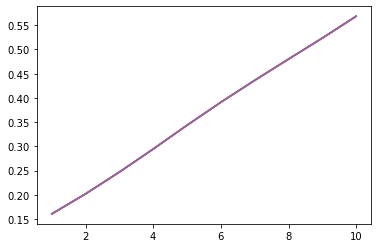

In [ ]:
for i in result:
    plt.plot([x for x in range(1,11)], [j.data for j in i])

plt.show()